In [3]:
import pickle
import os
import networkx as nx
import walker as w
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import norm

In [4]:
with open('../../data/graphs/3000_similar_noUnknown_noFutureThr2_noIsolates.pkl', 'rb') as f:
    G = pickle.load(f)

In [ ]:
# with open('../../data/batch/B_random_10.pkl', 'rb') as f:
#     B_random = pickle.load(f)
with open('../../data/batch/B_100k.pkl', 'rb') as f:
    B_recent = pickle.load(f)

In [ ]:
graph_nodes = list(G.nodes())

In [ ]:
def ids_to_indices(file_ids, nodes):
    index_map = {node: i for i, node in enumerate(nodes)}
    index_map_keys = set(index_map.keys())
    
    indices = []
    for file, ids in file_ids.items():
        for id in ids:
            if id in index_map_keys:
                indices.append(index_map[id])
    return indices

In [ ]:
B_recent_idx = ids_to_indices(B_recent, graph_nodes)

In [ ]:
walks = w.random_walks(G, n_walks=25, walk_len=4, start_nodes=B_recent_idx)

In [ ]:
walks

In [ ]:
unique_walks = walks[~np.all(walks == walks[:,[0]], axis=1)]
print(len(walks) - len(unique_walks))
walks = unique_walks

In [ ]:
# group walks by first node
walks_by_start = defaultdict(list)

for row in walks:
    walks_by_start[row[0]].append(row)
    
for key in walks_by_start:
    walks_by_start[key] = np.array(walks_by_start[key]).flatten()

In [ ]:
# get unique ids for each walk
for key, walk_nodes in walks_by_start.items():
    ids = set(walk_nodes)
    # remove start node
    ids.remove(key)

    walks_by_start[key] = ids

In [ ]:
# filter out nodes with less than 10 neighbors
# walks_by_start = {key: nodes for key, nodes in walks_by_start.items() if len(nodes) >= 10}

In [ ]:
def plot_counts(node_walks, bins=100):
    counts = []
    for key, walk_nodes in node_walks.items():
        counts.append(len(walk_nodes))

    # print(len(counts), np.average(counts), np.median(counts), np.min(counts), np.max(counts))
    print(f"Number of target nodes: {len(counts)}")
    print(f"Average number of nodes in khop: {np.average(counts)}")
    print(f"Median number of nodes in khop: {np.median(counts)}")
    print(f"Min number of nodes in khop: {np.min(counts)}")
    print(f"Max number of nodes in khop: {np.max(counts)}")

    plt.hist(counts, bins=bins)
    plt.show()

def count_khop(khops, bins=100):
    target_counts = []
    khop_counts = []
    for targets, khop in khops:
        target_counts.append(len(targets))
        khop_counts.append(len(khop))

    print(f"Batch count: {len(target_counts)}")
    print(f"Graphs per batch: {np.average(target_counts)}")
    print(f"Average batch nodes: {np.average(khop_counts)}")
    print(f"Median batch nodes: {np.median(khop_counts)}")
    print(f"Min batch nodes: {np.min(khop_counts)}")
    print(f"Max batch nodes: {np.max(khop_counts)}")

    plt.hist(khop_counts, bins=bins)
    plt.show()

In [ ]:
plot_counts(walks_by_start, bins=88)

In [ ]:
target_nodes = walks_by_start.keys()

In [ ]:
khops = []
for target_node in target_nodes:
    khop = set(walks_by_start[target_node])
    targets = {target_node}
    khops.append((targets, khop))

In [ ]:
def merge_khops(current_khops: list):
    unmerged = current_khops.copy() # array of (set(targets), set(khop))
    merged_khops = []
    errs = 0
    for _ in (pbar := tqdm(range(len(unmerged) // 2))):
        # randomly pick two graphs to merge
        idx1, idx2 = np.random.choice(len(unmerged), 2, replace=False)
        graph1, graph2 = unmerged[idx1], unmerged[idx2]

        targets1, khop1 = graph1
        targets2, khop2 = graph2

        # check if targets and khops overlap
        overlap = False
        for i, k in ([targets1, khop2], [targets2, khop1]):
            # check if any target is in the other's khop
            if len(i.intersection(k)) > 0:
                # dont merge
                overlap = True
                break

        if overlap:
            errs += 1
            pbar.set_description(f'Merge conflicts: {errs}')
            continue

        # merge
        targets = targets1.union(targets2)
        khop = khop1.union(khop2)

        merged_khops.append((targets, khop))

        # remove merged graphs from unmerged
        unmerged = [graph for i, graph in enumerate(unmerged) if i not in [idx1, idx2]]

    return merged_khops, unmerged

def try_fully_merge(khops, tries=3):
    merged = []
    unmerged = khops.copy()

    for i in range(tries):
        tqdm.write(f'Try: {i+1}, {len(unmerged)} unmerged')

        m, unmerged = merge_khops(unmerged)
        merged = merged + m

        if len(unmerged) == 0:
            return merged

    print('Could not fully merge', len(unmerged))
    return merged + unmerged

In [ ]:
merged_khops = try_fully_merge(khops)

In [ ]:
count_khop(merged_khops, bins=70)

In [ ]:
merged_khops_2x = try_fully_merge(merged_khops)

In [ ]:
count_khop(merged_khops_2x, bins=60)

In [ ]:
merged_khops_3x = try_fully_merge(merged_khops_2x)

In [ ]:
count_khop(merged_khops_3x, bins=100)

In [ ]:
merged_khops_4x = try_fully_merge(merged_khops_3x)
count_khop(merged_khops_4x, bins=100)

In [ ]:
merged_khops_5x = try_fully_merge(merged_khops_4x)
count_khop(merged_khops_5x, bins=110)

In [ ]:
merged_khops_6x = try_fully_merge(merged_khops_5x)
count_khop(merged_khops_6x, bins=120)

In [ ]:
merged_khops_7x = try_fully_merge(merged_khops_6x)
count_khop(merged_khops_7x, bins=130)

In [ ]:
merged_khops_8x = try_fully_merge(merged_khops_7x, tries=10)
count_khop(merged_khops_8x, bins=140)

In [ ]:
def idx_to_id(idx):
    # idx is a single index or an array of indices
    return [graph_nodes[i] for i in idx]
def save_event_ids(merged_khops, filename, path='../../data/batch/'):
    to_save = []
    for targets, khop in merged_khops:
        to_save.append((idx_to_id(targets), idx_to_id(khop)))

    with open(path+filename, 'wb') as f:
        pickle.dump(to_save, f)

In [ ]:
save_event_ids(merged_khops_8x, 'B_recent_10_khops_12k.pkl')

In [ ]:
save_event_ids(merged_khops_7x, 'B_recent_10_khops_6k.pkl')

In [ ]:
save_event_ids(merged_khops_6x, 'B_recent_10_khops_3k.pkl')

In [ ]:
G = G.reverse(copy=False)

In [ ]:
ex_ids = merged_khops_6x[0]
ex_targets, ex_khop = ex_ids
ex_targets, ex_khop = idx_to_id(ex_targets), idx_to_id(ex_khop)
ex_subgraph = G.subgraph(ex_khop + ex_targets)

# draw subgraph, drawing the targets in red
plt.figure(figsize=(6,6))
node_color = ['red' if node in ex_targets else 'darkblue' for node in ex_subgraph.nodes()]

# Using spring_layout with a higher k value to increase space between nodes
pos = nx.spring_layout(ex_subgraph, k=0.1, iterations=45)  # You can adjust k and iterations as needed

nx.draw(ex_subgraph, pos, node_color=node_color, with_labels=False, node_size=25, width=0.1)
plt.show()

In [61]:
G = G.reverse(copy=False)

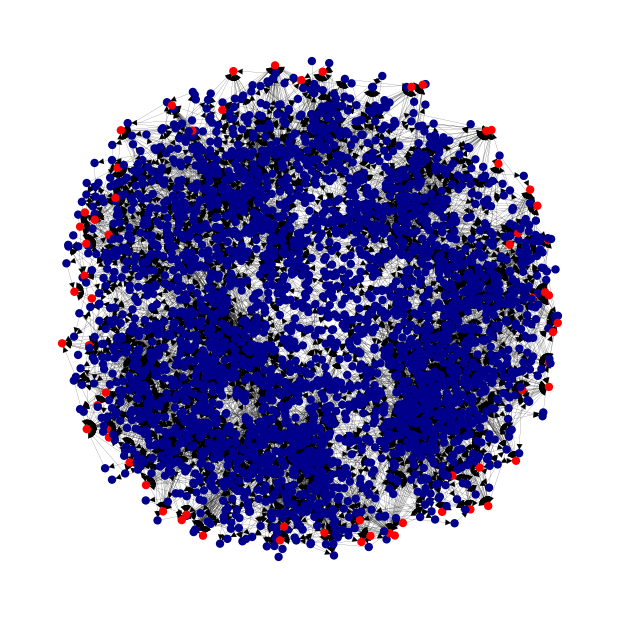

In [63]:
ex_ids = merged_khops_6x[0]
ex_targets, ex_khop = ex_ids
ex_targets, ex_khop = idx_to_id(ex_targets), idx_to_id(ex_khop)
ex_subgraph = G.subgraph(ex_khop + ex_targets)

# draw subgraph, drawing the targets in red
plt.figure(figsize=(6,6))
node_color = ['red' if node in ex_targets else 'darkblue' for node in ex_subgraph.nodes()]

# Using spring_layout with a higher k value to increase space between nodes
pos = nx.spring_layout(ex_subgraph, k=0.1, iterations=45)  # You can adjust k and iterations as needed

nx.draw(ex_subgraph, pos, node_color=node_color, with_labels=False, node_size=25, width=0.1)
plt.show()